In [97]:
import numpy as np

import matplotlib.pyplot as plt
import igraph as ig
from eptnr.datasets.dataset_loader import load_dataset
from eptnr.datasets.synthetic_datasets import SyntheticDatasets
from eptnr.rewards.sufficientarian import SufficientarianCostReward
from eptnr.constants.travel_metric import TravelMetric
from eptnr.rewards.utils.graph_computation_utils import get_tt_hops_com_dfs
from eptnr.analysis.full_problem_exploration import full_problem_exploration
import pandas as pd
from eptnr.algorithms.baselines.optimal_baseline import optimal_max_baseline
import seaborn as sns

# Dataset loading

In [98]:
graph, census = load_dataset(SyntheticDatasets.ONE)

# Data Anaysis

In [99]:
def plot_travel_time_histogram(graph, census):
    tt_df, _, _ = get_tt_hops_com_dfs(graph, census, 50)
    temp_tt_df = tt_df.copy()
    categories = pd.Categorical(temp_tt_df['group'])
    temp_tt_df['group'] = categories
    temp_tt_df = temp_tt_df.pivot(columns='group')

    melted_temp_tt = temp_tt_df.melt()[['group', 'value']]
    melted_temp_tt.value = pd.to_numeric(melted_temp_tt.value)
    ax = sns.histplot(melted_temp_tt, x='value', hue='group', multiple='dodge', shrink=.75, bins=20,
                      palette=categories.unique().to_list())
    ax.vlines(melted_temp_tt.value.mean(), ymin=0, ymax=melted_temp_tt.groupby('group').count().max(), linestyles="dashed")
    return ax

<AxesSubplot: xlabel='value', ylabel='Count'>

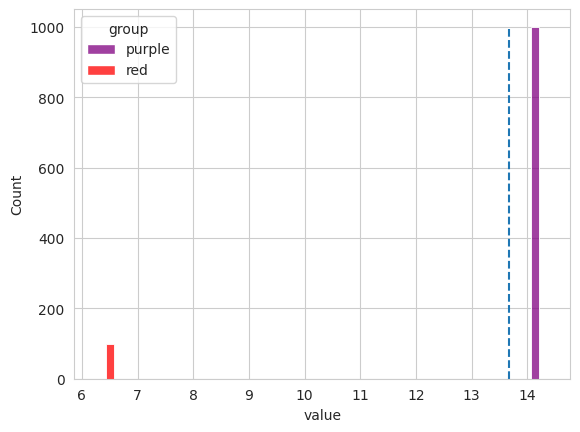

In [100]:
plot_travel_time_histogram(graph, census)

# Reward setup

In [101]:
graph.es.select(type_ne='walk')['cost']

[50, 50, 50, 50]

In [102]:
total_graph_cost = sum(graph.es.select(type_ne='walk')['cost'])
total_graph_cost

200

In [103]:
sufficiency = {
    TravelMetric.TT: 20
}

monetary_budget = 150
groups = None
metrics = [TravelMetric.TT]


reward = SufficientarianCostReward(census_data=census, com_threshold=0,
                                   sufficiency=sufficiency, total_graph_cost=total_graph_cost, monetary_budget=monetary_budget,
                                   groups=groups, metrics=metrics, verbose=True)

# Algorithms

In [104]:
edge_types = set(graph.es.select(type_ne='walk')['type'])
solutions = optimal_max_baseline(graph, reward, edge_types=edge_types)

  0%|          | 0/15 [00:00<?, ?it/s]INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Received graph with:
	n_edges=15	n_vertices=6Created subgraph:
	n_edges=15
	n_vertices=6
	available_edges=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Resulting rewards:
	calculated_reward=-0.0
	scaled_reward=-0.0
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/algorithms/baselines/optimal_baseline.py:For state [] obtained rewards -30.0
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Received graph with:
	n_edges=15	n_vertices=6Created subgraph:
	n_edges=14
	n_vertices=6
	available_edges=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
INFO:/home/rico/Documents/equitable-transport-reduction/eptnr_package/eptnr/rewards/base_reward.py:Resulting rewards:
	calculated_reward=-1

In [105]:
solutions

[([-33.33333333333333, -21.428571428571427, -0.0], [12, 13, 14])]

# Evaluation

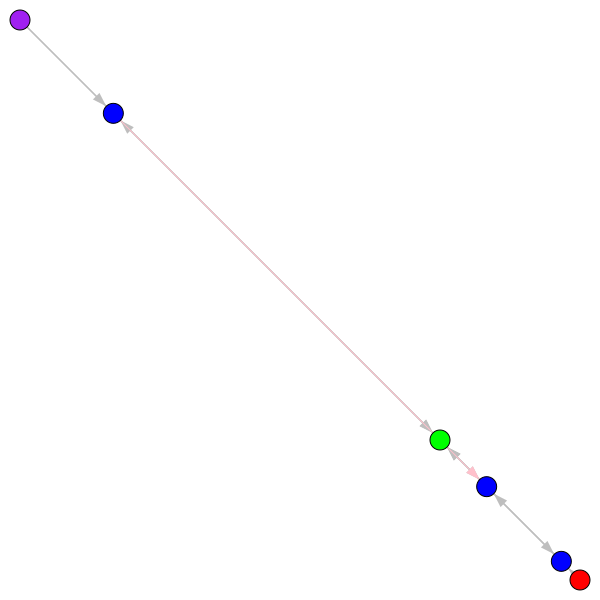

In [106]:
graph_prime = graph.subgraph_edges([e.index for e in graph.es if e.index not in solutions[0][1]])
ig.plot(graph_prime)


<AxesSubplot: xlabel='value', ylabel='Count'>

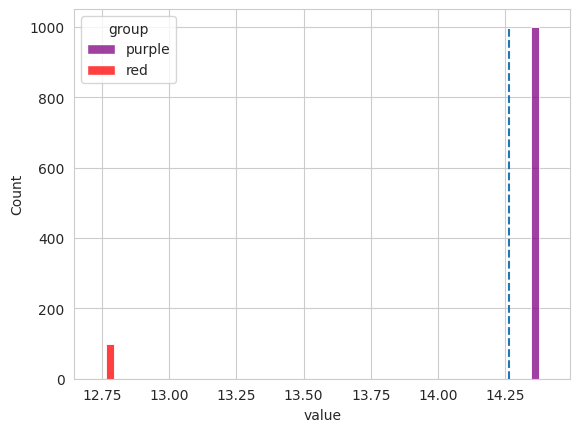

In [107]:
plot_travel_time_histogram(graph_prime, census)